In [327]:
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt

In [328]:
SEED = 42
# NumPy random
np.random.seed(SEED)
# PyTorch random
torch.manual_seed(SEED)
# If you have a GPU
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
g = torch.Generator().manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# LSTM Cell Walkthrough

![LSTM architecture](lstm_arch.png)

We consider a single LSTM cell with input dimension 5, hidden dimension 3, and batch size 1.  

The input at time $t$ is  
$$
x_t = [x_1, x_2, x_3, x_4, x_5] \quad (1 \times 5)
$$  

The previous hidden state is  
$$
h_{t-1} = [h_1, h_2, h_3] \quad (1 \times 3)
$$  

The previous cell state is  
$$
c_{t-1} = [c_1, c_2, c_3] \quad (1 \times 3)
$$  


The forget gate uses the following parameters:  
$$
W_f =
\begin{bmatrix}
W^f_{11} & W^f_{12} & W^f_{13} & W^f_{14} & W^f_{15} \\
W^f_{21} & W^f_{22} & W^f_{23} & W^f_{24} & W^f_{25} \\
W^f_{31} & W^f_{32} & W^f_{33} & W^f_{34} & W^f_{35}
\end{bmatrix}
\quad (3 \times 5),
$$  

$$
U_f =
\begin{bmatrix}
U^f_{11} & U^f_{12} & U^f_{13} \\
U^f_{21} & U^f_{22} & U^f_{23} \\
U^f_{31} & U^f_{32} & U^f_{33}
\end{bmatrix}
\quad (3 \times 3),
$$  

$$
b_f = [b^f_1, b^f_2, b^f_3] \quad (3,).
$$  

The computation is  
$$
z_f = x_t W_f^T + h_{t-1} U_f^T + b_f, \quad f_t = \sigma(z_f).
$$  



The input gate has parameters  
$$
W_i \in \mathbb{R}^{3 \times 5}, \quad U_i \in \mathbb{R}^{3 \times 3}, \quad b_i \in \mathbb{R}^3,
$$  
with computation  
$$
z_i = x_t W_i^T + h_{t-1} U_i^T + b_i, \quad i_t = \sigma(z_i).
$$  



The candidate vector has parameters  
$$
W_g \in \mathbb{R}^{3 \times 5}, \quad U_g \in \mathbb{R}^{3 \times 3}, \quad b_g \in \mathbb{R}^3,
$$  
with computation  
$$
z_g = x_t W_g^T + h_{t-1} U_g^T + b_g, \quad g_t = \tanh(z_g).
$$  



The new cell state is updated as  
$$
c_t = f_t \odot c_{t-1} + i_t \odot g_t,
$$  
which preserves part of the old memory and adds new information.  



The output gate has parameters  
$$
W_o \in \mathbb{R}^{3 \times 5}, \quad U_o \in \mathbb{R}^{3 \times 3}, \quad b_o \in \mathbb{R}^3,
$$  
with computation  
$$
z_o = x_t W_o^T + h_{t-1} U_o^T + b_o, \quad o_t = \sigma(z_o).
$$  

Finally, the hidden state is  
$$
h_t = o_t \odot \tanh(c_t).
$$  



In this setting all $W$ matrices are $(3 \times 5)$, all $U$ matrices are $(3 \times 3)$, all biases $b$ are $(3,)$, and the outputs $f_t, i_t, g_t, o_t, c_t, h_t$ are vectors of size $(1 \times 3)$.


In [329]:
def construct_variables(T=4000, noise_std=0.05, seed=SEED):
    """
    Constructs a synthetic time series regression problem with 3 observable features and 1 target.
    The target depends on lagged values of the features, a hidden trend, and heteroscedastic noise.
    Parameters
    ----------
    T : int, length of the time series
    noise_std : float, base standard deviation of the noise
    seed : int, random seed for reproducibility

    Returns
    -------
    t : (T-5,) time index
    X : (T-5, 3) observable features
    y : (T-5,) target variable
    vol : (T-5,) moving volatility of the noise
    """
    rng = np.random.default_rng(seed)
    t = np.arange(T)

    # 3 observable features
    f1 = np.sin(0.2 * t)                 
    f2 = np.cos(0.15 * t + 0.5)    
    t_norm = (t - t.min()) / (t.max() - t.min())
    f3 = t_norm                               
    #f3 = t

    X = np.stack([f1, f2, f3], axis=1)

    # hidden unobserved trend
    hidden_trend =  t * 0.001       

    # moving volatility
    vol = noise_std * (0.5 +  np.abs(np.sin(0.02 * t)))
    noise = rng.normal(0, vol)

    # Assume that the target is then given by: 
    # y_t = 0.5 * f1_{t-1} - 0.3 * f2_{t-3} + 0.2 * f3_{t-5} + hidden_trend_t + noise_t
    y = (
        0.5 * np.roll(f1, 1)   # f1 lag 1
      - 0.3 * np.roll(f2, 3)   # f2 lag 3
      + hidden_trend
      + noise
    )

    # discard contaminated first 5 obs
    max_lag = 5
    t = t[max_lag:]
    X = X[max_lag:]
    y = y[max_lag:]
    vol = vol[max_lag:]

    return t.astype(np.float32), X.astype(np.float32), y.astype(np.float32), vol.astype(np.float32)

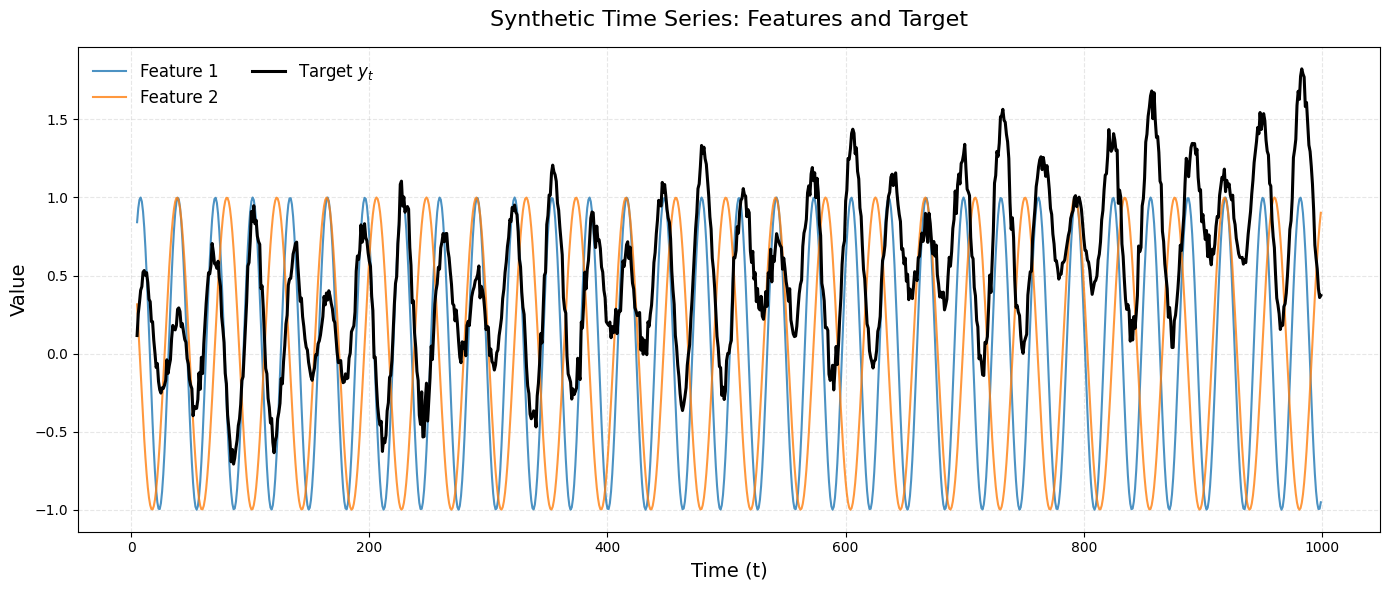

In [330]:
# Construct the dataset:
t, X_all, y_all, vol_all = construct_variables(T=1000, noise_std=0.05, seed=42) # shape (T-5, 3), (T-5,), (T-5,)

# --- Plot all components and the target ---
plt.figure(figsize=(14, 6))

# plot last 1000 points for clarity
window = 1000
t_plot = t[-window:]
X_plot = X_all[-window:]
y_plot = y_all[-window:]

plt.plot(t_plot, X_plot[:, 0], label="Feature 1", alpha=0.8, linewidth=1.5)
plt.plot(t_plot, X_plot[:, 1], label="Feature 2", alpha=0.8, linewidth=1.5)
#plt.plot(t_plot, X_plot[:, 2], label="Feature 3", alpha=0.8, linewidth=1.5)

plt.plot(t_plot, y_plot, label="Target $y_t$", color="black", linewidth=2.2)

plt.title("Synthetic Time Series: Features and Target", fontsize=16, pad=15)
plt.xlabel("Time (t)", fontsize=14)
plt.ylabel("Value", fontsize=14)

plt.legend(fontsize=12, ncol=2, frameon=False)
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

In [331]:
def create_sliding_windows(X, y, seq_len=20):
    """
    Turn (X, y) into sliding windows for sequence forecasting.

    Parameters
    ----------
    X : array (T, n_features)
    y : array (T,)
    seq_len : int, number of lags to use as input

    Returns
    -------
    X_seq : (n_samples, seq_len, n_features)
    y_seq : (n_samples,)
    """
    n_samples = len(X) - seq_len     # len(X) returns number of rows (t)
    X_seq = []
    y_seq = []
    for i in range(n_samples):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])

    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


def train_val_test_split(X_seq, y_seq, train_frac=0.7, val_frac=0.2):
    """
    Split into train, validation, test sets (time-ordered).
    """
    n = len(X_seq)
    n_train = int(n * train_frac)
    n_val   = int(n * val_frac)

    X_train, y_train = X_seq[:n_train], y_seq[:n_train]
    X_val,   y_val   = X_seq[n_train:n_train+n_val], y_seq[n_train:n_train+n_val]
    X_test,  y_test  = X_seq[n_train+n_val:], y_seq[n_train+n_val:]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [332]:
# Create sliding windows:
X_seq, y_seq = create_sliding_windows(X_all, y_all, seq_len=20)
# Split into train, val, test:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(X_seq, y_seq, train_frac=0.7, val_frac=0.2)

# Convert NumPy arrays to torch tensors
train_X_t = torch.tensor(X_train)   # shape: (n_train, seq_len, n_features)
train_y_t = torch.tensor(y_train)   # shape: (n_train,)

val_X_t   = torch.tensor(X_val)
val_y_t   = torch.tensor(y_val)

test_X_t  = torch.tensor(X_test)
test_y_t  = torch.tensor(y_test)

# Wrap into TensorDataset
train_ds = TensorDataset(train_X_t, train_y_t)
val_ds   = TensorDataset(val_X_t, val_y_t)
test_ds  = TensorDataset(test_X_t, test_y_t)

# If on CUDA: pin_memory speeds host→device copies
pin = (device.type == "cuda")

# Create DataLoaders (batches)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=pin, generator=g)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, pin_memory=pin)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, pin_memory=pin)

In [333]:
# Define an LSTM forecasting model by subclassing nn.Module
class LSTMForecaster(nn.Module):
    def __init__(self, n_features, hidden_size=32, num_layers=1, dropout=0.0):

        # Call parent constructor (nn.Module gives us useful PyTorch functionality)
        super().__init__()

        # LSTM layer:       
        self.lstm = nn.LSTM(
            input_size=n_features,              # input_size = number of features per time step (t)
            hidden_size=hidden_size,            # hidden_size = size of hidden state
            num_layers=num_layers,              # num_layers = how many stacked LSTM layers
            batch_first=True,                   # batch_first=True -> input/output shape is (batch, seq_len, features)
        )

        self.fc = nn.Linear(hidden_size, 1)     # Fully connected layer: maps hidden state -> scalar prediction

    def forward(self, x):
        # x shape: (batch, seq_len, n_features)
        # out: LSTM outputs at all time steps (batch, seq_len, hidden_size)
        # h_n: final hidden state for each layer (num_layers, batch, hidden_size)
        # c_n: final cell state (num_layers, batch, hidden_size)
        out, (h_n, c_n) = self.lstm(x)

        # Take the hidden state from the last layer:
        last_hidden = h_n[-1]   # shape: (batch, hidden_size)

        # Pass through fully connected layer -> shape (batch, 1)
        # squeeze(-1) removes the last dimension -> shape (batch,)
        return self.fc(last_hidden).squeeze(-1)

In [334]:
# Model: input has 3 features per time step
model = LSTMForecaster(n_features=3, hidden_size=32, num_layers=1)
model = model.to(device)  # Move model to GPU if available

# Loss function: Mean Squared Error (good for regression)
criterion = nn.MSELoss()

# Optimizer: Adam (common choice for deep learning)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [335]:
n_epochs = 100  # number of passes over the dataset
patience = 10   # for early stopping
best_val_loss = np.inf
train_losses = []
val_losses = []


for epoch in range(n_epochs):

    # --- TRAINING ---

    model.train()                               # set model to training mode 
    train_loss = 0.0

    for xb, yb in train_loader:

        # Move batch to device
        xb, yb = xb.to(device), yb.to(device)
        
        # Forward pass
        preds = model(xb)                       # shape: (batch,)
        loss = criterion(preds, yb)             # compute MSE loss

        # Backward pass
        optimizer.zero_grad()                   # reset gradients
        loss.backward()                         # compute gradients
        optimizer.step()                        # update weights

        train_loss += loss.item() * xb.size(0)  # accumulate total loss per batch

    train_loss /= len(train_loader.dataset)     # average over all training samples
    train_losses.append(train_loss)

    # --- VALIDATION ---

    model.eval()                                # set model to evaluation mode (disables dropout, etc.)
    val_loss = 0.0
    with torch.no_grad():                       # no gradients for validation
        for xb, yb in val_loader:
            # Move batch to device
            xb, yb = xb.to(device), yb.to(device)

            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1:2d}/{n_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # --- EARLY STOPPING CHECK ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # save best model weights
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_state)  # restore best weights
            break

Epoch  1/100 - Train Loss: 0.2453 - Val Loss: 0.4005
Epoch  2/100 - Train Loss: 0.1420 - Val Loss: 0.1391
Epoch  3/100 - Train Loss: 0.0725 - Val Loss: 0.0891
Epoch  4/100 - Train Loss: 0.0291 - Val Loss: 0.0568
Epoch  5/100 - Train Loss: 0.0151 - Val Loss: 0.0230
Epoch  6/100 - Train Loss: 0.0063 - Val Loss: 0.0081
Epoch  7/100 - Train Loss: 0.0043 - Val Loss: 0.0066
Epoch  8/100 - Train Loss: 0.0041 - Val Loss: 0.0077
Epoch  9/100 - Train Loss: 0.0041 - Val Loss: 0.0067
Epoch 10/100 - Train Loss: 0.0043 - Val Loss: 0.0068
Epoch 11/100 - Train Loss: 0.0039 - Val Loss: 0.0064
Epoch 12/100 - Train Loss: 0.0037 - Val Loss: 0.0066
Epoch 13/100 - Train Loss: 0.0037 - Val Loss: 0.0068
Epoch 14/100 - Train Loss: 0.0036 - Val Loss: 0.0066
Epoch 15/100 - Train Loss: 0.0035 - Val Loss: 0.0076
Epoch 16/100 - Train Loss: 0.0038 - Val Loss: 0.0058
Epoch 17/100 - Train Loss: 0.0036 - Val Loss: 0.0074
Epoch 18/100 - Train Loss: 0.0038 - Val Loss: 0.0059
Epoch 19/100 - Train Loss: 0.0037 - Val Loss: 

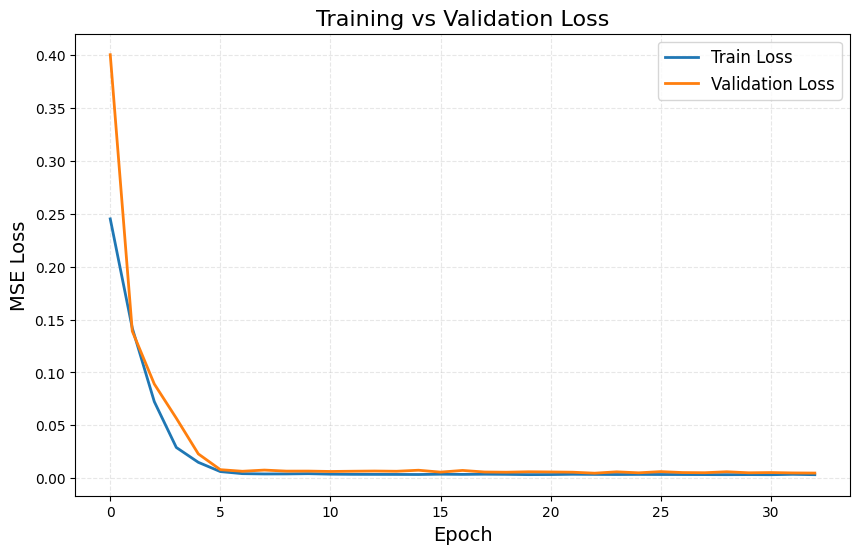

In [336]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label="Train Loss", linewidth=2)
plt.plot(val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("MSE Loss", fontsize=14)
plt.title("Training vs Validation Loss", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3, linestyle="--")
plt.show()


In [337]:
model.eval()  # set to evaluation mode

all_preds = []
all_true = []

with torch.no_grad():  # no gradients during evaluation
    for xb, yb in test_loader:
        # Move batch to device
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)          # forecasts
        all_preds.append(preds.detach().cpu().numpy()) 
        all_true.append(yb.detach().cpu().numpy())

# Concatenate all batches into single arrays
all_preds = np.concatenate(all_preds)
all_true = np.concatenate(all_true)

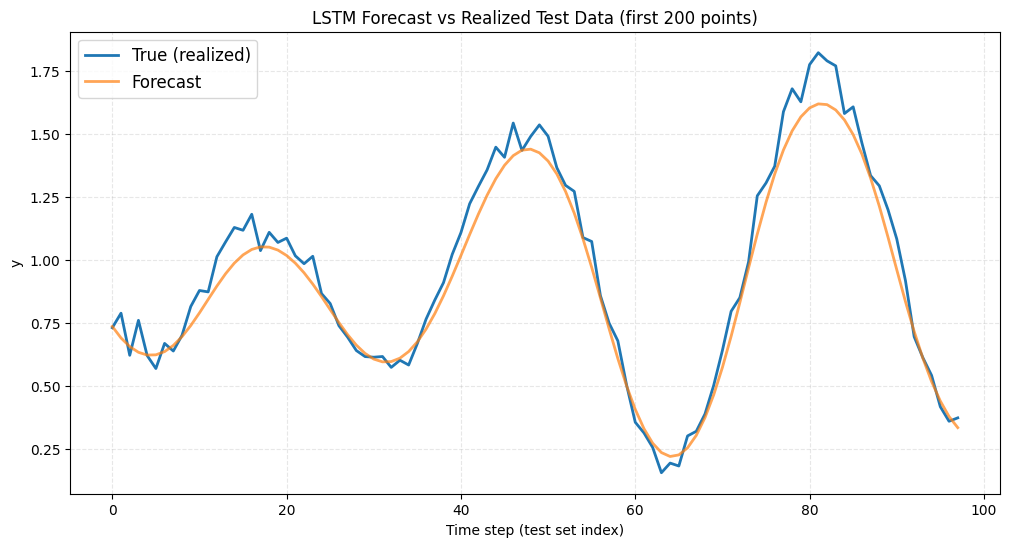

In [338]:
plt.figure(figsize=(12,6))
plt.plot(all_true[:200], label="True (realized)", linewidth=2)
plt.plot(all_preds[:200], label="Forecast", linewidth=2, alpha=0.7)
plt.title("LSTM Forecast vs Realized Test Data (first 200 points)")
plt.xlabel("Time step (test set index)")
plt.ylabel("y")
plt.legend(fontsize=12)
plt.grid(alpha=0.3, linestyle="--")
plt.show()